In [1]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),  # Convert PIL image or numpy.ndarray to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the pixel values to the range [-1, 1]
])


In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
def init_weights(m):
    # m is the name of each layer
    # then the entire class
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Any layer other than Conv, will have weight initialization
        # A layer with conv in it will not be -1
        # the output of find method is -1 if there is no match
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [71]:
class Generator(nn.Module):
    # All Conv Net is used in both generator and discriminator
    def __init__(self, ng, nc):
        super().__init__()
        self.convt1 = nn.ConvTranspose2d(latent_dim, ng*8, kernel_size=(4, 4), stride=2, padding=0)
        self.convt2 = nn.ConvTranspose2d(ng*8, ng*4, kernel_size=(4, 4), stride=2, padding=1)
        self.convt3 = nn.ConvTranspose2d(ng*4, ng*2, kernel_size=(4, 4), stride=2, padding=1)
        self.convt4 = nn.ConvTranspose2d(ng*2, ng*1, kernel_size=(4, 4), stride=2, padding=1)
        self.convt5 = nn.ConvTranspose2d(ng*1, nc, kernel_size=(4, 4), stride=2, padding=1)
        
        self.b1 = nn.BatchNorm2d(ng*8)
        self.b2 = nn.BatchNorm2d(ng*4)
        self.b3 = nn.BatchNorm2d(ng*2)
        self.b4 = nn.BatchNorm2d(ng*1)
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.relu(self.b1(self.convt1(x)))
        x = self.relu(self.b2(self.convt2(x)))
        x = self.relu(self.b3(self.convt3(x)))
        x = self.relu(self.b4(self.convt4(x)))
        x = self.tanh(self.convt5(x))
        
        return x

In [7]:
gen = Generator()
noise = torch.randn(1, latent_dim, 1, 1)
one_hot_in = nn.functional.one_hot(torch.tensor([5]), num_classes=10)
print(noise.shape, one_hot_in.shape)
# joint = torch.cat([noise, one_hot_in], dim=-1)
print(joint.shape)

img = gen(noise)
print(img.shape)

torch.Size([1, 100, 1, 1]) torch.Size([1, 10])
torch.Size([1, 110, 1, 1])
torch.Size([1, 1, 64, 64])


In [60]:
class Discriminator(nn.Module):
    def __init__(self, nd, nc):
        super().__init__()
        self.conv1 = nn.Conv2d(1, nd*1, 4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(nd*1, nd*2, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(nd*2, nd*4, 4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(nd*4, nd*8, 4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(nd*8, nc, 4, stride=2, padding=0)
        
        self.bn1 = nn.BatchNorm2d(nd*2)
        self.bn2 = nn.BatchNorm2d(nd*4)
        self.bn3 = nn.BatchNorm2d(nd*8)
        
        self.relul = nn.LeakyReLU(0.2)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        B, C, H, W = x.shape
        x = self.conv1(x)
        x = self.relul(x)
        
        x = self.conv2(x)
        x = self.bn1(x)
        x = self.relul(x)
        
        x = self.conv3(x)
        x = self.bn2(x)
        x = self.relul(x)
        
        x = self.conv4(x)
        x = self.bn3(x)
        x = self.relul(x)
        
        x = self.conv5(x)
        x = x.flatten(start_dim=1)
        
        x = self.sigmoid(x)
        
        return x

In [72]:
ng = 128
nd = 128
nc = 1

criterion = nn.BCELoss()

device=torch.device( "cuda" if (torch.cuda.is_available()) else 'cpu')
generator = Generator(ng, nc).to(device)
discriminator = Discriminator(nd, nc).to(device)

generator.apply(init_weights)
discriminator.apply(init_weights)

generator_opt = optim.Adam(generator.parameters(), lr=0.0002, betas = (0.5, 0.999))
discriminator_opt = optim.Adam(discriminator.parameters(), lr=0.0002, betas = (0.5, 0.999))

In [11]:
def plot_samples(num_samples):
    num_samples = 10
#     noise = torch.randn(num_samples, 100, 1, 1).to(device)
    noise = torch.randn(num_samples, latent_dim, 1, 1).to(device)
    with torch.no_grad():
        fake_images = generator(noise).cpu().detach().permute(0, 2, 3, 1).numpy()

    plt.figure()
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')

In [12]:
def reset_grad():
    generator_opt.zero_grad()
    discriminator_opt.zero_grad()

In [13]:
def train_generator(batch_size):
    real_labels = torch.ones(batch_size, 1).to(device)
#     noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
    fake_images = generator(noise)
    outputs = discriminator(fake_images)
    
    g_loss = criterion(outputs, real_labels)

    # Ascend the Stochastic Gradient of -log(D(G(z))) # becomes unstable
    # log(1 - D(G(z)))
#     g_loss = torch.mean(1-torch.log(outputs + 1e-4))
    
    g_loss.backward()
    generator_opt.step()
    
    return g_loss.item()

In [14]:
def train_discriminator(batch_size, real_images):
    real_labels = torch.ones(batch_size, 1).to(device)
    real_outputs = discriminator(real_images)
    d_loss_real = criterion(real_outputs, real_labels)

    # Ascend the Stochastic Gradient of -log(D(x)) # becomes unstable
#     d_loss_real = torch.mean(-torch.log(real_outputs + 1e-4))
    
    fake_labels = torch.zeros(batch_size, 1).to(device)
    noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
#     noise = torch.randn(batch_size, latent_dim).to(device)
    fake_images = generator(noise)
    fake_outputs = discriminator(fake_images)
    d_loss_fake = criterion(fake_outputs, fake_labels)

    # Minimize -log(1 - D(G(z))) # becomes unstable
#     d_loss_fake = torch.mean(-torch.log(1 - fake_outputs + 1e-4))
    
    d_loss = d_loss_real + d_loss_fake
    
    d_loss.backward()
    discriminator_opt.step()
    
    return d_loss

0 tensor(9.3923) tensor(1.2112)
tensor(9.3923) tensor(1.2112)


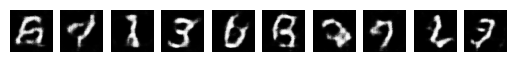

1 tensor(2.1849) tensor(0.9074)
tensor(5.7886) tensor(1.0593)


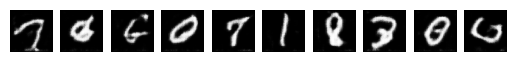

2 tensor(2.9880) tensor(0.7267)
tensor(4.8550) tensor(0.9484)


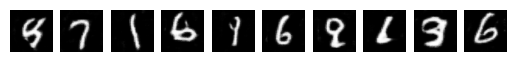

3 tensor(3.5445) tensor(0.5955)
tensor(4.5274) tensor(0.8602)


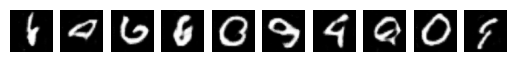

4 tensor(3.6140) tensor(0.5903)
tensor(4.3447) tensor(0.8062)


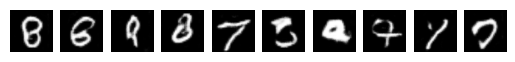

5 tensor(3.7146) tensor(0.5272)
tensor(4.2397) tensor(0.7597)


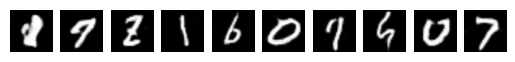

6 tensor(3.9781) tensor(0.4386)
tensor(4.2023) tensor(0.7139)


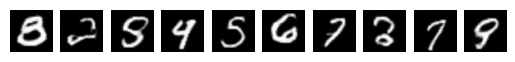

7 tensor(3.7564) tensor(0.5086)
tensor(4.1466) tensor(0.6882)


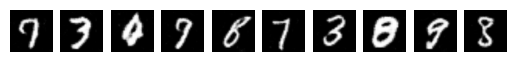

8 tensor(3.7857) tensor(0.5045)
tensor(4.1065) tensor(0.6678)


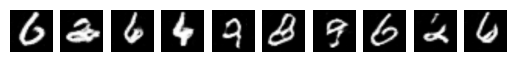

9 tensor(4.1888) tensor(0.3699)
tensor(4.1147) tensor(0.6380)


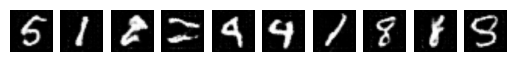

In [73]:
epochs = 10
latent_dim = 90
batch_size = 128
num_samples = 10

d_losses, g_losses = list(), list()

for epoch in range(epochs):
    mean_d, mean_g = list(), list()
    for images, _ in train_loader:
        batch_size = images.size(0)
        real_images = images.to(device)
        
        reset_grad()
        d_loss = train_discriminator(batch_size, real_images)
        mean_d.append(d_loss)
        
        reset_grad()
        g_loss = train_generator(batch_size)
        mean_g.append(g_loss)
        
    d_losses.append(torch.mean(torch.tensor(mean_d)))
    g_losses.append(torch.mean(torch.tensor(mean_g)))
        
    if epoch % 1 == 0:
        print(epoch, torch.mean(torch.tensor(mean_g)), torch.mean(torch.tensor(mean_d)))
        print(torch.mean(torch.tensor(g_losses)), torch.mean(torch.tensor(d_losses)))
        plot_samples(num_samples)
        plt.show()

In [29]:
print(batch_size)
noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
gen_out = generator(noise)
dis_out = discriminator(gen_out)

real_labels = torch.ones(batch_size, 1).to(device)
fake_labels = torch.zeros(batch_size, 1).to(device)

criterion(dis_out, real_labels), criterion(discriminator(images.to(device)), real_labels)


128


(tensor(0., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>),
 tensor(0., device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>))

In [21]:
discriminator(images[:6].to(device))

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
gen.apply(lambda x: print(x.__class__.__name__.find('Conv')))

In [ ]:
noise = torch.randn(B, latent_dim)
one_hot_in = nn.functional.one_hot(torch.tensor([5]), num_classes=num_classes)
print(noise.shape, one_hot_in.shape)
joint = torch.cat([noise, one_hot_in], dim=-1)
print(joint.shape)

project = nn.Linear(110, 4*4*1024)
out1 = project(joint)
print(out1.shape)

out1 = out1.view(B, 1024, 4, 4)
print(out1.shape)

convt1 = nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=2, padding=1, output_padding=0)
out2 = convt1(out1)
print(out2.shape)

convt2 = nn.ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=2, padding=1, output_padding=0)
out3 = convt2(out2)
print(out3.shape)

convt3 = nn.ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=2, padding=1, output_padding=0)
out4 = convt3(out3)
print(out4.shape)

convt4 = nn.ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=2, padding=1, output_padding=0)
out5 = convt4(out4)
print(out5.shape)

In [ ]:
nn.functional.one_hot(torch.tensor([5, 6]), num_classes=10)

In [ ]:
emd = nn.Embedding(10, 10)
emd(torch.tensor([5, 6]))